In [1]:

#import library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import scipy.io as scio 
import scipy.io as sio
from tf_utils import random_mini_batches_GCN1, convert_to_one_hot
from tensorflow.python.framework import ops
import hdf5storage
#from tfdeterminism import patch
#patch()

In [2]:
def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

def create_placeholders(n_x, n_x1, n_y):

    isTraining = tf.placeholder_with_default(True, shape=())
    x_in = tf.placeholder(tf.float32,  [None, n_x], name = "x_in")
    x_in1 = tf.placeholder(tf.float32,  [None, n_x1], name = "x_in1")
    y_in = tf.placeholder(tf.float32, [None, n_y], name = "y_in")
    lap_train = tf.placeholder(tf.float32, [None, None], name = "lap_train")
    
    return x_in, x_in1, y_in, lap_train, isTraining

In [3]:
def initialize_parameters():
   
    tf.set_random_seed(1)

    x_w1 = tf.get_variable("x_w1", [200,128], initializer = tf.keras.initializers.glorot_normal(seed = 1))
    x_b1 = tf.get_variable("x_b1", [128], initializer = tf.zeros_initializer())  

    x_jw1 = tf.get_variable("x_jw1", [128,128], initializer = tf.keras.initializers.glorot_normal(seed = 1))
    x_jb1 = tf.get_variable("x_jb1", [128], initializer = tf.zeros_initializer())   
    
    x_jw2 = tf.get_variable("x_jw2", [128,16], initializer = tf.keras.initializers.glorot_normal(seed = 1))
    x_jb2 = tf.get_variable("x_jb2", [16], initializer = tf.zeros_initializer())   
    
    x_conv_w1 = tf.get_variable("x_conv_w1", [3,3,200,32], initializer = tf.keras.initializers.glorot_normal(seed = 1))
    x_conv_b1 = tf.get_variable("x_conv_b1", [32], initializer = tf.zeros_initializer())

    x_conv_w2 = tf.get_variable("x_conv_w2", [3,3,32,64], initializer = tf.keras.initializers.glorot_normal(seed = 1))
    x_conv_b2 = tf.get_variable("x_conv_b2", [64], initializer = tf.zeros_initializer())

    x_conv_w3 = tf.get_variable("x_conv_w3", [1,1,64,128], initializer = tf.keras.initializers.glorot_normal(seed = 1))
    x_conv_b3 = tf.get_variable("x_conv_b3", [128], initializer = tf.zeros_initializer())
    
    parameters = {"x_w1": x_w1,
                  "x_b1": x_b1,
                  "x_jw1": x_jw1,
                  "x_jb1": x_jb1,
                  "x_jw2": x_jw2,
                  "x_jb2": x_jb2,
                  "x_conv_w1": x_conv_w1,
                  "x_conv_b1": x_conv_b1,
                  "x_conv_w2": x_conv_w2,
                  "x_conv_b2": x_conv_b2,
                  "x_conv_w3": x_conv_w3,
                  "x_conv_b3": x_conv_b3}
                  
    return parameters


In [4]:
def GCN_layer(x_in, L_, weights):

    x_mid = tf.matmul(x_in, weights)
    x_out = tf.matmul(L_, x_mid)
    
    return x_out

def mynetwork(x, x1, parameters, Lap, isTraining, momentums = 0.9):

    x1 = tf.reshape(x1, [-1, 7, 7, 200], name = "x1")
    
    with tf.name_scope("x_layer_1"):

         x_z1_bn = tf.layers.batch_normalization(x, momentum = momentums, training = isTraining)        
         x_z1 = GCN_layer(x_z1_bn, Lap, parameters['x_w1']) + parameters['x_b1']
         x_z1_bn = tf.layers.batch_normalization(x_z1, momentum = momentums, training = isTraining)
         x_a1 = tf.nn.relu(x_z1_bn)

         x_conv_z1 = tf.nn.conv2d(x1, parameters['x_conv_w1'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_conv_b1'] 
         x_conv_z1_bn = tf.layers.batch_normalization(x_conv_z1, momentum = momentums, training = isTraining)   
         x_conv_z1_po = tf.layers.max_pooling2d(x_conv_z1_bn, 2, 2, padding='SAME')
         x_conv_a1 = tf.nn.relu(x_conv_z1_po)
                 
    with tf.name_scope("x_layer_2"):   

         x_conv_z2 = tf.nn.conv2d(x_conv_a1, parameters['x_conv_w2'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_conv_b2'] 
         x_conv_z2_bn = tf.layers.batch_normalization(x_conv_z2, momentum = momentums, training = isTraining)
         x_conv_z2_po = tf.layers.max_pooling2d(x_conv_z2_bn, 2, 2, padding='SAME')
         x_conv_a2 = tf.nn.relu(x_conv_z2_po)

    with tf.name_scope("x_layer_3"):
      
         x_conv_z3 = tf.nn.conv2d(x_conv_a2, parameters['x_conv_w3'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_conv_b3'] 
         x_conv_z3_bn = tf.layers.batch_normalization(x_conv_z3, momentum = momentums, training = isTraining)
         x_conv_z3_po = tf.layers.max_pooling2d(x_conv_z3_bn, 2, 2, padding='SAME')
         x_conv_a3 = tf.nn.relu(x_conv_z3_po)
         
         x_conv_a3_shape = x_conv_a3.get_shape().as_list()
         x_conv_z3_2d = tf.reshape(x_conv_a3, [-1, x_conv_a3_shape[1] * x_conv_a3_shape[2] * x_conv_a3_shape[3]])
                    
         joint_encoder_layer = x_a1 * x_conv_z3_2d
         
    with tf.name_scope("x_joint_layer_1"):
        
         x_zj1 = tf.matmul(joint_encoder_layer, parameters['x_jw1']) + parameters['x_jb1']     
         x_zj1_bn = tf.layers.batch_normalization(x_zj1, momentum = momentums, training = isTraining)                                 
         x_aj1 = tf.nn.relu(x_zj1_bn)   

    with tf.name_scope("x_layer_4"):
         x_zj2 = tf.matmul(x_aj1, parameters['x_jw2']) + parameters['x_jb2']     
                  
    l2_loss =  tf.nn.l2_loss(parameters['x_w1']) + tf.nn.l2_loss(parameters['x_jw1']) + tf.nn.l2_loss(parameters['x_jw2'])\
               + tf.nn.l2_loss(parameters['x_conv_w1']) + tf.nn.l2_loss(parameters['x_conv_w2'])  + tf.nn.l2_loss(parameters['x_conv_w3']) 
                
    return x_zj2, l2_loss

def mynetwork_optimaization(y_est, y_re, l2_loss, reg, learning_rate, global_step):
    
    y_re = tf.squeeze(y_re, name = 'y_re')
    
    with tf.name_scope("cost"):
         cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_est, labels = y_re)) +  reg * l2_loss
         
    with tf.name_scope("optimization"):
         update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
         optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost,  global_step=global_step)
         optimizer = tf.group([optimizer, update_ops])
         
    return cost, optimizer

In [5]:
def train_mynetwork(x_train, x_test, train_x, test_x, y_train, y_test, L_train, L_test, learning_rate_base = 0.001, beta_reg = 0.001, num_epochs = 200, minibatch_size = 32, print_cost = True):
    tf.compat.v1.disable_eager_execution()
    ops.reset_default_graph()    
    tf.set_random_seed(1)                          
    seed = 1                                                         
    (m, n_x) = x_train.shape
    (m, n_y) = y_train.shape
    (m, n_x1) = train_x.shape
    
    costs = []                                        
    costs_dev = []
    train_acc = []
    val_acc = []
    
    x_in, x_in1, y_in, lap_train, isTraining = create_placeholders(n_x, n_x1, n_y) 

    parameters = initialize_parameters()
    
    with tf.name_scope("network"):
         x_out, l2_loss = mynetwork(x_in, x_in1, parameters, lap_train, isTraining)

    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(learning_rate_base, global_step, 50 * m/minibatch_size, 0.5, staircase = True)
    
    with tf.name_scope("optimization"):
         cost, optimizer = mynetwork_optimaization(x_out, y_in, l2_loss, beta_reg, learning_rate, global_step)

    with tf.name_scope("metrics"):
         joint_layerT = tf.transpose(x_out)
         yT = tf.transpose(y_in)
         correct_prediction = tf.equal(tf.argmax(joint_layerT), tf.argmax(yT))
         accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
         
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        sess.run(init)

        # Do the training loop
        for epoch in range(num_epochs + 1):
            epoch_cost = 0.                       # Defines a cost related to an epoch
            epoch_acc = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches_GCN1(x_train, train_x, y_train, L_train, minibatch_size, seed)
            for minibatch in minibatches:

                # Select a minibatch
                (batch_x, batch_x1, batch_y, batch_l) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _, minibatch_cost, minibatch_acc = sess.run([optimizer, cost, accuracy], feed_dict={x_in: batch_x, x_in1: batch_x1, y_in: batch_y, lap_train: batch_l, isTraining: True})
           
                epoch_cost += minibatch_cost / (num_minibatches+ 1)
                epoch_acc += minibatch_acc / (num_minibatches + 1)
            
            
            if print_cost == True and (epoch) % 50 == 0:
                features, epoch_cost_dev, epoch_acc_dev = sess.run([x_out, cost, accuracy], feed_dict={x_in: x_test, x_in1: test_x, y_in: y_test, lap_train: L_test, isTraining: False})
                print ("epoch %i: Train_loss: %f, Val_loss: %f, Train_acc: %f, Val_acc: %f" % (epoch, epoch_cost, epoch_cost_dev, epoch_acc, epoch_acc_dev))
         
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                train_acc.append(epoch_acc)
                costs_dev.append(epoch_cost_dev)
                val_acc.append(epoch_acc_dev)
      
        # plot the cost      
        plt.plot(np.squeeze(costs))
        plt.plot(np.squeeze(costs_dev))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        # plot the accuracy 
        plt.plot(np.squeeze(train_acc))
        plt.plot(np.squeeze(val_acc))
        plt.ylabel('accuracy')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
   
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
     
        return parameters, val_acc, features

Instructions for updating:
Colocations handled automatically by placer.


/var/folders/z_/krw1gf615x7gd0lvqxvzk7ch0000gn/T/ipykernel_5699/2470277289.py:14: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  x_z1_bn = tf.layers.batch_normalization(x, momentum = momentums, training = isTraining)
/var/folders/z_/krw1gf615x7gd0lvqxvzk7ch0000gn/T/ipykernel_5699/2470277289.py:16: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  x_z1_bn = tf.layers.batch_normalization(x_z1, momentum = momentums, training = isTraining)
/var/folders/z_/krw1gf615x7gd0lvqxvzk

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



/var/folders/z_/krw1gf615x7gd0lvqxvzk7ch0000gn/T/ipykernel_5699/2470277289.py:46: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  x_zj1_bn = tf.layers.batch_normalization(x_zj1, momentum = momentums, training = isTraining)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-03 04:34:01.320092: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-03 04:34:01.320224: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-03 04:34:01.333047: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-02-03 04:34:01.369970: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-03 04:34:01.374308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 04:34:01.561396: I tensorflow/core/grappler/optimizers/custom_graph

epoch 0: Train_loss: 2.184612, Val_loss: 2.224193, Train_acc: 0.393125, Val_acc: 0.369558
epoch 50: Train_loss: 0.264727, Val_loss: 1.159327, Train_acc: 0.990057, Val_acc: 0.747389
epoch 100: Train_loss: 0.208422, Val_loss: 1.049219, Train_acc: 0.994318, Val_acc: 0.765174
epoch 150: Train_loss: 0.157556, Val_loss: 1.084347, Train_acc: 1.000000, Val_acc: 0.774687
epoch 200: Train_loss: 0.137091, Val_loss: 1.032420, Train_acc: 1.000000, Val_acc: 0.781202


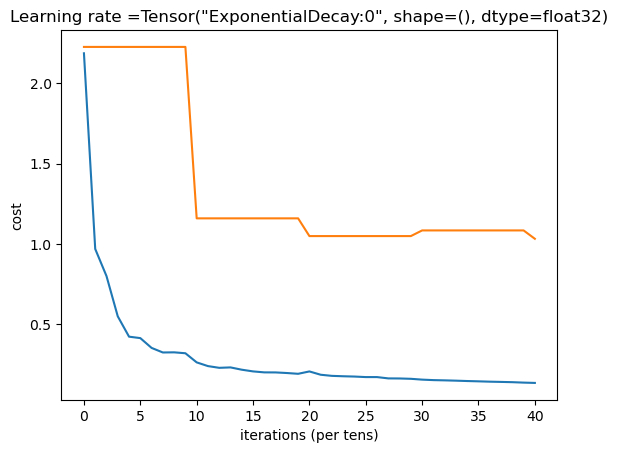

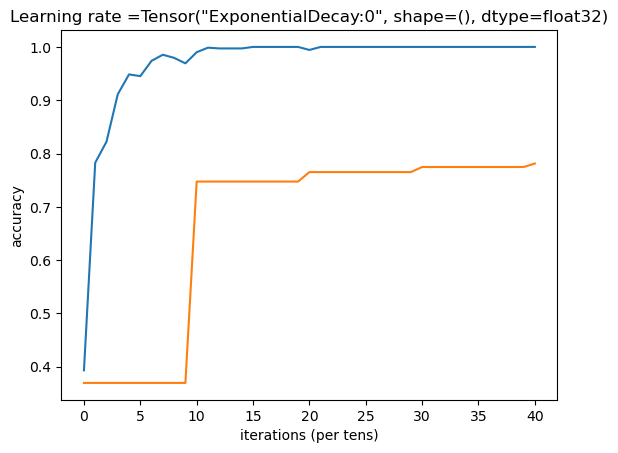

Parameters have been trained!


2023-02-03 04:37:57.918036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [6]:
X_train = scio.loadmat('/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Remote_sensing/seminar/hong/IEEE_TGRS_GCN-master/Indian pines datasets/HSI_CNN/X_train.mat')
X_test = scio.loadmat('/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Remote_sensing/seminar/hong/IEEE_TGRS_GCN-master/Indian pines datasets/HSI_CNN/X_test.mat')
Train_X = scio.loadmat('/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Remote_sensing/seminar/hong/IEEE_TGRS_GCN-master/Indian pines datasets/HSI_GCN/Train_X.mat')
TrLabel = scio.loadmat('/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Remote_sensing/seminar/hong/IEEE_TGRS_GCN-master/Indian pines datasets/HSI_GCN/TrLabel.mat')
Test_X = scio.loadmat('/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Remote_sensing/seminar/hong/IEEE_TGRS_GCN-master/Indian pines datasets/HSI_GCN/Test_X.mat')
TeLabel = scio.loadmat('/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Remote_sensing/seminar/hong/IEEE_TGRS_GCN-master/Indian pines datasets/HSI_GCN/TeLabel.mat')
Train_L = scio.loadmat('/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Remote_sensing/seminar/hong/IEEE_TGRS_GCN-master/Indian pines datasets/HSI_GCN/k10/fea_a/Cosine/Train_L.mat')
Test_L = hdf5storage.loadmat('/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Remote_sensing/seminar/hong/IEEE_TGRS_GCN-master/Indian pines datasets/HSI_GCN/k10/fea_a/Cosine/Test_L.mat')


X_train = X_train['X_train']
X_test = X_test['X_test']
Train_X = Train_X['Train_X']
Test_X = Test_X['Test_X']
TrLabel = TrLabel['TrLabel']
TeLabel = TeLabel['TeLabel']

Train_L = Train_L['Train_L']
Test_L = Test_L['Test_L']


TrLabel = convert_to_one_hot(TrLabel-1, 16)
TeLabel = convert_to_one_hot(TeLabel-1, 16)
TrLabel = TrLabel.T
TeLabel = TeLabel.T


parameters, val_acc, features = train_mynetwork(Train_X, Test_X, X_train, X_test, TrLabel, TeLabel, Train_L, Test_L)
sio.savemat('/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Remote_sensing/seminar/hong/IEEE_TGRS_GCN-master/Indian pines datasets/HSI_GCN/k10/features-m_feaa_C.mat', {'features': features})